In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
df1 = pd.read_csv("TSLA.csv", usecols = [1])
df2 = pd.read_csv("GOOGL.csv", usecols = [1])
df3 = pd.read_csv("DJI.csv", usecols = [1])

In [5]:
df['Open']

0        19.000000
1        25.790001
2        25.000000
3        23.000000
4        20.000000
5        16.400000
6        16.139999
7        17.580000
8        17.950001
9        17.389999
10       17.940001
11       19.940001
12       20.700001
13       21.370001
14       21.850000
15       20.660000
16       20.500000
17       21.190001
18       21.500000
19       20.910000
20       20.549999
21       20.770000
22       20.200001
23       20.500000
24       21.000000
25       21.950001
26       21.540001
27       20.100000
28       19.900000
29       19.650000
           ...    
2197    272.579987
2198    259.709991
2199    264.440002
2200    268.750000
2201    277.160004
2202    278.700012
2203    282.619995
2204    288.299988
2205    287.320007
2206    261.890015
2207    269.859985
2208    277.690002
2209    271.649994
2210    276.739990
2211    268.299988
2212    270.220001
2213    268.630005
2214    265.750000
2215    274.750000
2216    271.230011
2217    269.000000
2218    260.

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [4]:
min_max_scaler = MinMaxScaler()
df1['Open'] = min_max_scaler.fit_transform(df1.Open.values.reshape(-1,1))
df2['Open'] = min_max_scaler.fit_transform(df2.Open.values.reshape(-1,1))
df3['Open'] = min_max_scaler.fit_transform(df3.Open.values.reshape(-1,1))

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [5]:
valid_set_size_percentage = 10
test_set_size_percentage = 10
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [6]:
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df1, seq_len)

/anaconda2/envs/practicalnn_course/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [7]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df2, seq_len)

/anaconda2/envs/practicalnn_course/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [12]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df3, seq_len)

/anaconda2/envs/practicalnn_course/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [8]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2946, 19, 1)
y_train.shape =  (2946, 1)
x_valid.shape =  (368, 19, 1)
y_valid.shape =  (368, 1)
x_test.shape =  (368, 19, 1)
y_test.shape =  (368, 1)


# TesnorFlow Model

In [13]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 1 
n_neurons = 200 
n_outputs = 1
n_layers = 2
learning_rate = 0.001
batch_size = 20
n_epochs = 20 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              


# Training

In [14]:
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.064147/0.153683
5.00 epochs: MSE train/valid = 0.000019/0.000143
10.00 epochs: MSE train/valid = 0.000015/0.000031
15.00 epochs: MSE train/valid = 0.000013/0.000036


In [22]:
np.savetxt('y_test_pred_TSLA',y_test_pred,delimiter=',')
np.savetxt('y_train_pred_TSLA',y_train_pred,delimiter=',')
np.savetxt('y_test_TSLA',y_test,delimiter=',')
np.savetxt('y_train_TSLA',y_train,delimiter=',')

In [11]:
np.savetxt('y_test_pred_GOOGL',y_test_pred,delimiter=',')
np.savetxt('y_train_pred_GOOGL',y_train_pred,delimiter=',')
np.savetxt('y_test_GOOGL',y_test,delimiter=',')
np.savetxt('y_train_GOOGL',y_train,delimiter=',')

In [15]:
np.savetxt('y_test_pred_DJI',y_test_pred,delimiter=',')
np.savetxt('y_train_pred_DJI',y_train_pred,delimiter=',')
np.savetxt('y_test_DJI',y_test,delimiter=',')
np.savetxt('y_train_DJI',y_train,delimiter=',')

# Testing

In [3]:
y_test_pred_t=np.loadtxt('y_test_pred_TSLA',delimiter=',')
y_train_pred_t=np.loadtxt('y_train_pred_TSLA',delimiter=',')
y_test_t=np.loadtxt('y_test_TSLA',delimiter=',')
y_train_t=np.loadtxt('y_train_TSLA',delimiter=',')

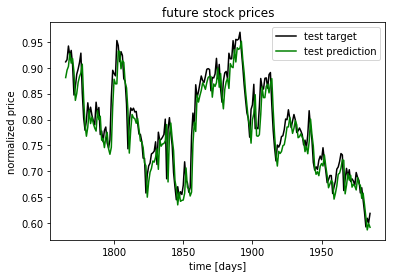

In [4]:
plt.plot(np.arange(y_train_t.shape[0], y_train_t.shape[0]+y_test_t.shape[0]),
         y_test_t, color='black', label='test target')

plt.plot(np.arange(y_train_pred_t.shape[0], y_train_pred_t.shape[0]+y_test_pred_t.shape[0]),
         y_test_pred_t, color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [ ]:
y_test_pred_t=np.loadtxt('y_test_pred_GOOGL',delimiter=',')
y_train_pred_t=np.loadtxt('y_train_pred_GOOGL',delimiter=',')
y_test_t=np.loadtxt('y_test_GOOGL',delimiter=',')
y_train_t=np.loadtxt('y_train_GOOGL',delimiter=',')

In [ ]:
y_test_pred_t=np.loadtxt('y_test_pred_DJI',delimiter=',')
y_train_pred_t=np.loadtxt('y_train_pred_DJI',delimiter=',')
y_test_t=np.loadtxt('y_test_DJI',delimiter=',')
y_train_t=np.loadtxt('y_train_DJI',delimiter=',')